In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
from tqdm.notebook import tqdm

In [2]:
def getVar(simn, var, iter):
    file = open(f'sims/sim{simn}/mesh_fc_{iter}.vtk')
    # file = open(f'sims/sim_looong_5/plateMesh_{i}.vtk')
    arr = []
    lines = file.readlines()
    j = 0
    while f'SCALARS {var} double 1\n' != lines[j]:
        j += 1
    j += 2
    while True:
        try:
            arr.append(float(lines[j]))
            j += 1
        except:
            break
    return np.array(arr)

def getVarHist(simn, var, iter=None):
    arrs = []
    if iter is None:
        iter = 500
    for i in tqdm(range(iter+1)):
        try:
            arrs.append(getVar(simn, var, i))
        except:
            continue
    return np.array(arrs)

def getMainAxis(arrs, n, m):
    i = np.arange(m-1)*n + int(n*7/8)
    i = i[:,None] + np.concatenate([np.arange(-5, 5), np.arange(-5, 5) - n//2])[None,:]
    # i = i[:,None] + np.arange(-5, 5)[None,:]
    return np.max(arrs[...,i], axis=-1)

def getN(arrs):
    arrs[arrs == 0] = 1e18
    return np.cumsum(np.min(arrs, axis=1))

def getCrackLen(psis):
    return np.argmax(psis < 0.5, axis=-1)

48928.49
47683.54
46769.08
48011.97
old 5
02 4
01 6
005 11


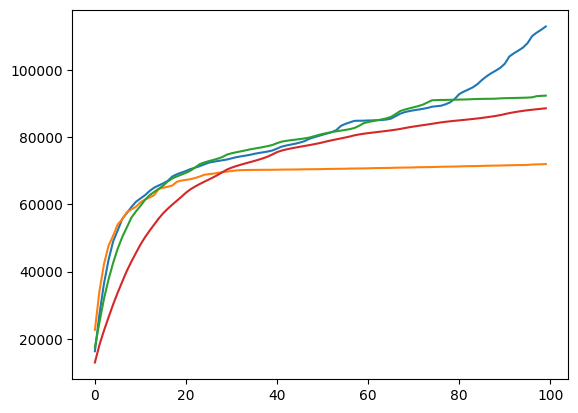

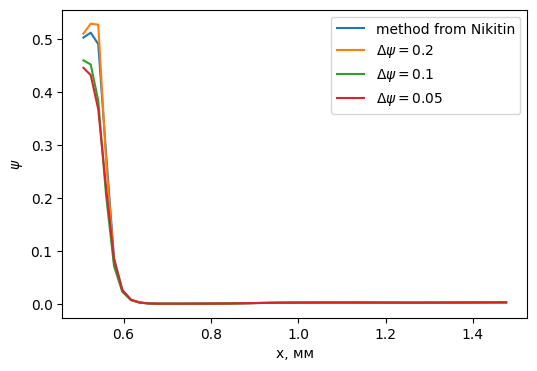

array([0.00972502, 0.01125292, 0.00242845, 0.        ])

In [235]:
ks = []
ss = ['old', '02', '01', '005']#, '002']
for s in ss:
    ns = getN(getVarHist('3dpsi'+s, 'deltaN'))
    k = np.searchsorted(ns, 5e4)
    ks.append(k)
    print(ns[k-1])
    plt.plot(ns[:100])

plt.figure(figsize=(6,4), dpi=100)
psis = []
for s, k in zip(ss, ks):
    print(s, k)
    psi = getMainAxis(getVar('3dpsi'+s, 'psi', k), 200, 35)
    psis.append(psi)
    alpha = np.linspace(0, 1, 35)
    xs = (0.5**(1-alpha) * 1.5**alpha)
    xs = (xs[:-1] + xs[1:])/2
    lab = f'$\Delta \psi = 0.{s[1:]}$' if s != 'old' else 'method from Nikitin'
    plt.plot(xs, psi, label=lab)
plt.legend()
plt.xlabel('x, мм')
plt.ylabel('$\psi$')

# plt.title('Повреждения при разных методах расчета $\Delta N$')
plt.show()

psis = np.array(psis)
np.mean(np.abs(psis - psis[3]), axis=1)

In [52]:
ss = ['old', '02', '01', '005', '002']
psis = []
for s in ss:
    psi = getMainAxis(getVarHist('dpsi'+s, 'psi'), 200, 35)
    psis.append(psi)

old 16 0.647491138341244 5979818.0
02 11 0.647491138341244 4277720.0
01 22 0.647491138341244 6781975.0
005 41 0.647491138341244 7386844.0
002 97 0.647491138341244 7640542.999999999


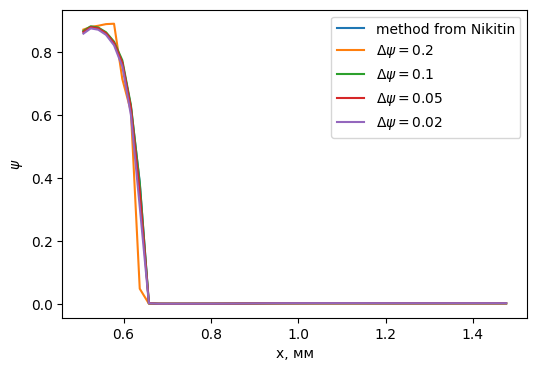

In [53]:
ss = ['old', '02', '01', '005', '002']
ks = []

plt.figure(figsize=(6,4), dpi=100)
for i, s in enumerate(ss):
    k = 0
    while np.searchsorted(np.sort(psis[i][k]), 0.6) > len(psis[i][k]) - 7:
        k += 1
    # if s == '002':
    #     k -= 1
    psis.append(psi)
    alpha = np.linspace(0, 1, 35)
    xs = (0.5**(1-alpha) * 1.5**alpha)
    print(s, k, xs[8], getN(getVarHist('dpsi'+s, 'deltaN', k))[-1])
    xs = (xs[:-1] + xs[1:])/2
    lab = f'$\Delta \psi = 0.{s[1:]}$' if s != 'old' else 'method from Nikitin'
    plt.plot(xs, psis[i][k], label=lab)
plt.legend()
plt.xlabel('x, мм')
plt.ylabel('$\psi$')

plt.show()

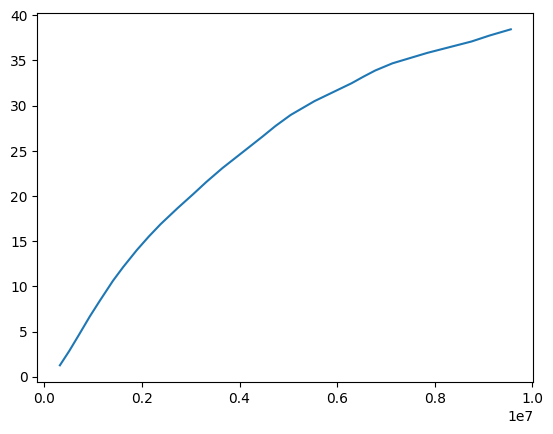

In [54]:
s = '01'
# psi = getMainAxis(getVarHist('dpsi'+s, 'psi', 100), 200, 35)
psi = getVarHist('dpsi'+s, 'psi', 100)
n = getN(getVarHist('dpsi'+s, 'deltaN', 100))
psi = psi[n < 1e7]
n = n[n < 1e7]
plt.plot(n, np.sum(psi, axis=1))

old 45 0.647491138341244 177096117.0
02 48 0.647491138341244 174564711.0
01 58 0.647491138341244 156624078.0


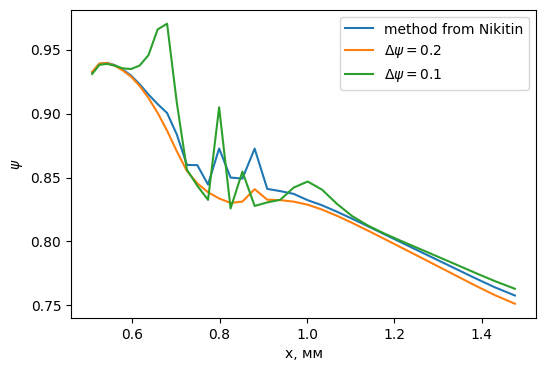

In [55]:
ss = ['old', '02', '01']#, '005', '002']
ks = []

plt.figure(figsize=(6,4), dpi=100)
for i, s in enumerate(ss):
    k = 0
    while np.min(psis[i][k]) < 0.75:
        k += 1
    psis.append(psi)
    alpha = np.linspace(0, 1, 35)
    xs = (0.5**(1-alpha) * 1.5**alpha)
    print(s, k, xs[8], getN(getVarHist('dpsi'+s, 'deltaN', k))[-1])
    xs = (xs[:-1] + xs[1:])/2
    lab = f'$\Delta \psi = 0.{s[1:]}$' if s != 'old' else 'method from Nikitin'
    plt.plot(xs, psis[i][k], label=lab)
plt.legend()
plt.xlabel('x, мм')
plt.ylabel('$\psi$')

plt.show()

144612.36600000004
[  1.5022139  -17.98609654]
176698.1674
[  2.14472378 -25.81686965]
177374.53869999986
[  4.13598945 -50.22528191]


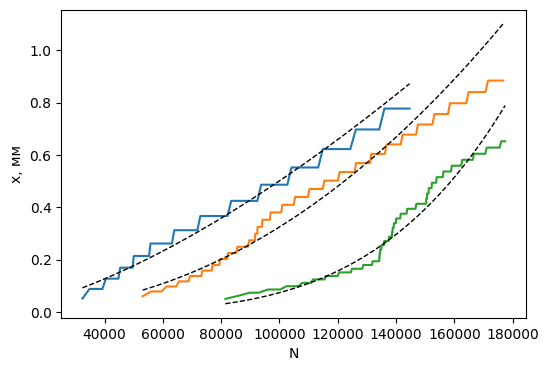

In [239]:
k = 2
plt.figure(figsize=(6,4), dpi=100)
for k in range(1, 4):
    shift = (k+1) % 2
    n, m = k*100, (k*35+1)//2
    psi = getMainAxis(getVarHist(f'2dh{k}', 'psi'), n, m)
    ns = getN(getVarHist(f'2dh{k}', 'deltaN'))
    alpha = np.linspace(0, 1, m)
    xs = (0.5**(1-alpha) * 1.5**alpha)
    xs = (xs[:-1] + xs[1:])/2 - .5
    cl = getCrackLen(psi)
    which = (cl > 0) & (cl < m-3)
    ns = ns[which]
    cl = cl[which]
    xs = xs[cl]
    
    plt.plot(ns, xs)

    coef = np.polyfit(np.log(ns), np.log(xs), 1)
    plt.plot(ns, np.exp(np.polyval(coef, np.log(ns))), '--k', linewidth=1)
    print(coef)
    # coef = np.polyfit(ns, xs, 1)
    # plt.plot(ns, np.polyval(coef, ns), '--k', linewidth=1)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('N')
plt.ylabel('x, мм')
plt.show()

[ 0.45671509 -7.58622166]
[ 0.40598495 -7.17827962]
[ 0.40483976 -7.2599982 ]


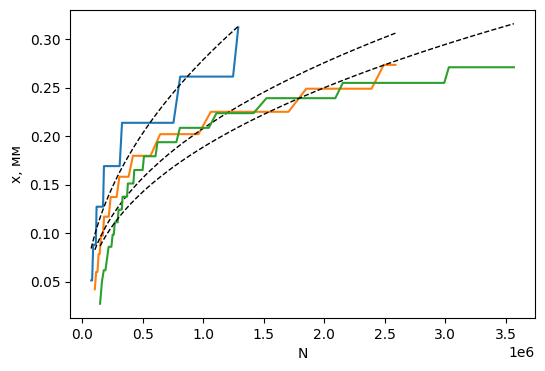

In [240]:
k = 2
plt.figure(figsize=(6,4), dpi=100)
for k in range(1, 4):
    shift = (k+1) % 2
    n, m = k*100, (k*35+1)//2
    psi = getMainAxis(getVarHist(f'dh{k}', 'psi'), n, m)
    ns = getN(getVarHist(f'dh{k}', 'deltaN'))
    alpha = np.linspace(0, 1, m)
    xs = (0.5**(1-alpha) * 1.5**alpha)
    xs = (xs[:-1] + xs[1:])/2 - .5
    cl = getCrackLen(psi)
    which = (cl > 0) & (cl < m-3)
    ns = ns[which]
    cl = cl[which]
    xs = xs[cl]
    
    plt.plot(ns, xs)

    coef = np.polyfit(np.log(ns), np.log(xs), 1)
    plt.plot(ns, np.exp(np.polyval(coef, np.log(ns))), '--k', linewidth=1)
    print(coef)
    # coef = np.polyfit(ns, xs, 1)
    # plt.plot(ns, np.polyval(coef, ns), '--k', linewidth=1)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('N')
plt.ylabel('x, мм')
plt.show()

In [ ]:
k = 2
plt.figure(figsize=(6,4), dpi=100)
for k in range(1, 4):
    shift = (k+1) % 2
    n, m = k*100, (k*35+1)//2
    psi = getMainAxis(getVarHist(f'2dpsi{k}', 'psi'), n, m)
    ns = getN(getVarHist(f'2dh{k}', 'deltaN'))
    alpha = np.linspace(0, 1, m)
    xs = (0.5**(1-alpha) * 1.5**alpha)
    xs = (xs[:-1] + xs[1:])/2 - .5
    cl = getCrackLen(psi)
    which = (cl > 0) & (cl < m-3)
    ns = ns[which]
    cl = cl[which]
    xs = xs[cl]
    print(ns[-1])

    
    plt.plot(ns, xs)

    coef = np.polyfit(np.log(ns), np.log(xs), 1)
    plt.plot(ns, np.exp(np.polyval(coef, np.log(ns))), '--k', linewidth=1)
    print(coef)
    # coef = np.polyfit(ns, xs, 1)
    # plt.plot(ns, np.polyval(coef, ns), '--k', linewidth=1)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel('N')
plt.ylabel('x, мм')
plt.show()

Text(0, 0.5, 'x, мм')

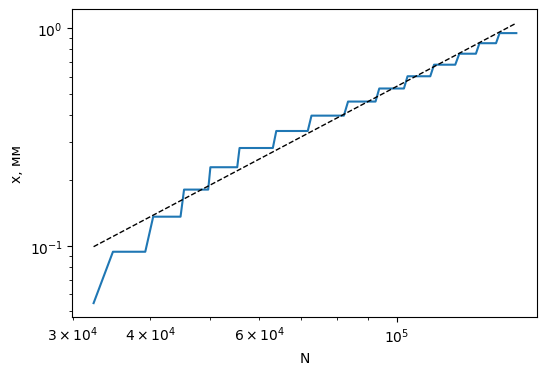

In [76]:
coef = np.polyfit(np.log(ns), np.log(xs), 1)

plt.figure(figsize=(6,4), dpi=100)
plt.plot(ns, xs)
plt.plot(ns, np.exp(np.polyval(coef, np.log(ns))), '--k', linewidth=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('x, мм')

In [261]:
print(getMainAxis(getVar(f'rand1', 'psi', 50), 100, 18).min())
print(getN(getVarHist(f'rand1', 'deltaN'))[49])

print(getMainAxis(getVar(f'dh1', 'psi', 45), 100, 18).min())
print(getN(getVarHist(f'dh1', 'deltaN'))[44])


print(getMainAxis(getVar(f'dh2', 'psi', 52), 200, 35).min())
print(getN(getVarHist(f'dh2', 'deltaN'))[51])

0.534695
3922403.7
0.586616
1337905.49
0.438309
2587722.8499999996


In [3]:
print(getMainAxis(getVar(f'rand1', 'psi', 50), 100, 18).min())
print(getN(getVarHist(f'rand1', 'deltaN'))[49])

print(getMainAxis(getVar(f'notrand', 'psi', 43), 100, 18).min())
print(getN(getVarHist(f'notrand', 'deltaN'))[42])

0.534695


  0%|          | 0/501 [00:00<?, ?it/s]

3922403.7
0.336873


  0%|          | 0/501 [00:00<?, ?it/s]

3530528.5


In [262]:
print(getMainAxis(getVar(f'2dh1', 'psi', 99), 100, 18).min())
print(getN(getVarHist(f'2dh1', 'deltaN'))[98])

print(getMainAxis(getVar(f'2dh2', 'psi', 253), 200, 35).min())
print(getN(getVarHist(f'2dh2', 'deltaN'))[252])

print(getMainAxis(getVar(f'2dh4', 'psi', 253), 200, 35).min())
print(getN(getVarHist(f'2dh4', 'deltaN'))[252])

0.516218
169004.986
0.57665
181575.98040000003


In [5]:
def plotPsiN(name, n, m):
    psi = getMainAxis(getVarHist(name, 'psi'), n, m)
    ns = getN(getVarHist(name, 'deltaN'))
    alpha = np.linspace(0, 1, m)
    xs = (0.5**(1-alpha) * 1.5**alpha)
    xs = (xs[:-1] + xs[1:])/2 - .5
    cl = getCrackLen(psi)
    which = (cl > 0) & (cl < m-3)
    ns = ns[which]
    cl = cl[which]
    xs = xs[cl]
    
    plt.plot(ns, xs)
    print(ns[-1])
    coef = np.polyfit(np.log(ns), np.log(xs), 1)
    plt.plot(ns, np.exp(np.polyval(coef, np.log(ns))), '--k', linewidth=1)

  0%|          | 0/501 [00:00<?, ?it/s]

  0%|          | 0/501 [00:00<?, ?it/s]

200037.11834000002


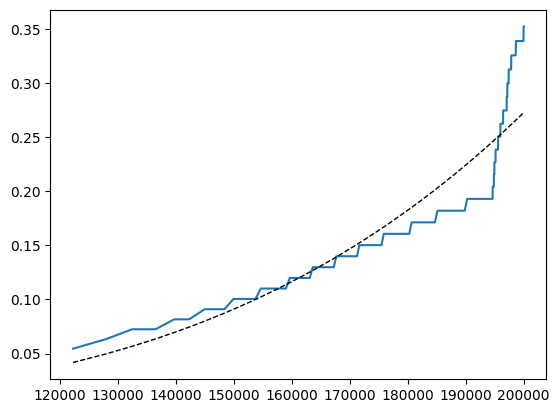

In [6]:
plotPsiN('2dh4', 400, 70)

  0%|          | 0/501 [00:00<?, ?it/s]

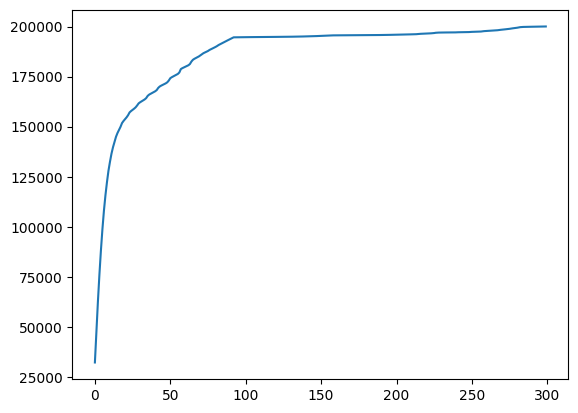

In [8]:
plt.plot(getN(getVarHist('2dh4', 'deltaN')))

In [136]:
k = 1
shift = 0 if k == 1 else -1
n, m = k*100, k*35//2
psis = getVarHist('2dpsiold', 'psi')
psi1 = getMainAxis(psis, n, m, 0+shift)
psi2 = getMainAxis(psis, n, m, -n//2+shift)
ns = getN(getVarHist('2dpsiold', 'deltaN'))
alpha = np.linspace(0, 1, m)
xs = (0.5**(1-alpha) * 1.5**alpha)
xs = (xs[:-1] + xs[1:])/2
cl1 = getCrackLen(psi1)
cl2 = getCrackLen(psi2)
which = (np.minimum(cl1, cl2) > 1) & (np.maximum(cl1, cl2) < m-1)
ns = ns[which]
cl1 = cl1[which]
cl2 = cl2[which]
xs = (xs[cl1] + xs[cl2]) / 2 - 0.5
print(ns[-1])

149093.03599999993


Text(0, 0.5, 'x, мм')

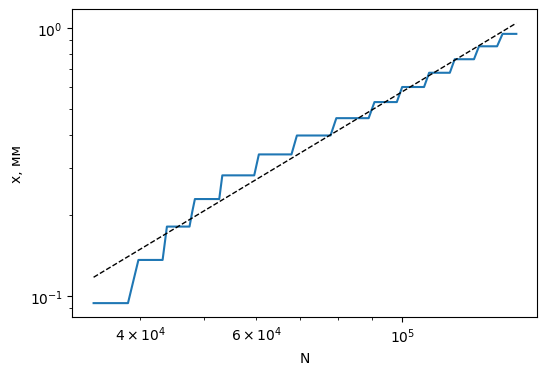

In [137]:
coef = np.polyfit(np.log(ns), np.log(xs), 1)

plt.figure(figsize=(6,4), dpi=100)
plt.plot(ns, xs)
plt.plot(ns, np.exp(np.polyval(coef, np.log(ns))), '--k', linewidth=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('x, мм')

In [64]:
ns = getN(getVarHist('dh5', 'deltaN'))
ns[65]

2584222.3

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

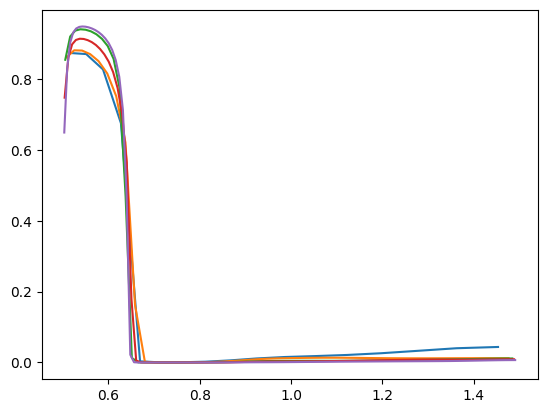

In [93]:
ns = []
for i, k in [(1, 20), (2, 26), (3, 31), (4, 33), (5, 36)]:
    psi = getVar(f'dh{i}', 'psi', k)
    n, m = 100*i, int(np.ceil(35*i/2))
    alpha = np.linspace(0, 1, m)
    xs = (0.5**(1-alpha) * 1.5**alpha)
    xs = (xs[:-1] + xs[1:])/2
    plt.plot(xs, getMainAxis(psi, n, m))
    deltan = getN(getVarHist(f'dh{i}', 'deltaN', k))[k-1]
    ns.append(deltan)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (5,) and (100,)

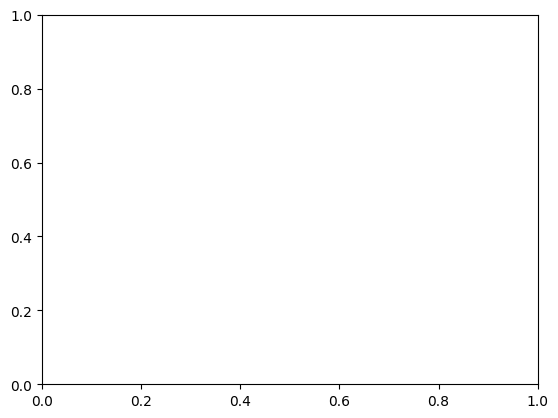

In [65]:
ns = np.array(ns)
ns /= ns[0]
plt.plot(np.arange(1, 6)*100, ns)
plt.show()

In [40]:
i=2
psi = getVar(f'dh{i}', 'psi')
deltan = getN(getVar(f'dh{i}', 'deltaN'))
n, m = 100*i, int(np.ceil(35*i/2))
alpha = np.linspace(0, 1, m)
xs = (0.5**(1-alpha) * 1.5**alpha)
xs = (xs[:-1] + xs[1:])/2

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

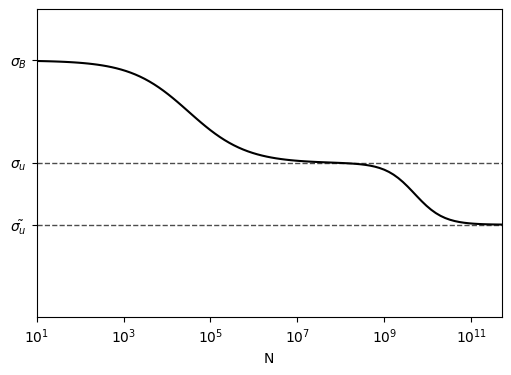

In [47]:
x = np.linspace(1, 11.7, 100)

def sigmoid(x, a, b):
    return 1 / (np.exp((-x + a)*b) + 1)

y = 1 - sigmoid(x, 4.5, 1.5) - sigmoid(x, 9.7, 3)*.6

x = 10**x

plt.figure(figsize=(6,4))
plt.plot(x, y, 'k')
plt.plot([10, 10**11.7], [0, 0], '--k', linewidth=1, alpha=0.7)
plt.plot([10, 10**11.7], [-.6, -.6], '--k', linewidth=1, alpha=0.7)
plt.ylim(-1.5, 1.5)
plt.xlim(10, 10**11.7)
plt.xscale('log')
plt.xlabel('N')
plt.yticks([1, 0, -.6], ['$\sigma_B$', '$\sigma_u$', '$\\tilde{\sigma_u}$'])
plt.savefig('wohler.pdf')